In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
pd.set_option('display.max_columns', 500)

# Load Data

In [2]:
DATA_PATH = 'MDataFiles_Stage2/'

for filename in os.listdir(DATA_PATH):
    print(filename)

MNCAATourneyDetailedResults.csv
MNCAATourneyCompactResults.csv
MSeasons.csv
MMasseyOrdinals_thruDay128.csv
MRegularSeasonDetailedResults.csv
MNCAATourneySlots.csv
MGameCities.csv
MConferenceTourneyGames.csv
Cities.csv
MRegularSeasonCompactResults.csv
MNCAATourneySeedRoundSlots.csv
MTeamConferences.csv
MSampleSubmissionStage2.csv
MTeamCoaches.csv
Conferences.csv
MTeams.csv
MNCAATourneySeeds.csv
MSecondaryTourneyTeams.csv
MTeamSpellings.csv
MSecondaryTourneyCompactResults.csv


## Seeds

In [3]:
df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
df_seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2417,2022,Z13,1151
2418,2022,Z14,1255
2419,2022,Z15,1174
2420,2022,Z16a,1136


## Slots

In [4]:
df_slot = pd.read_csv(DATA_PATH + "MNCAATourneySlots.csv")
df_slot

,Season,Slot,StrongSeed,WeakSeed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12
...,...,...,...,...
2380,2022,R6CH,R5WX,R5YZ
2381,2022,W12,W12a,W12b
2382,2022,X11,X11a,X11b
2383,2022,Y16,Y16a,Y16b


## Season detailed results

In [5]:
# 命中率--> 防守
# DayNum 順序 加一點權重
# Wloc 主客場 改dummy
# WFGM 命中數 WFGA 出手數 --> 可算兩三分球命中率＋3分手出手數
# WFTM 罰球 罰球數
# OR 進攻籃板 (DR防守籃板)
# Ast 助攻
# TO 失誤
# Stl 抄截
# Blk 火鍋
# PF 犯規

## 進攻
# TS公式 算真實命中率
# 進攻失誤率 TOV% - Turnover Percentage (available since the 1977-78 season in the NBA); the formula is 100 * TOV / (FGA + 0.44 * FTA + TOV). Turnover percentage is an estimate of turnovers per 100 plays.

## 防守
# AST/TO 傳球有沒有用

In [6]:
df_season_d = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")

In [7]:
df_season_d.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [8]:
# 主客場
df_season_d['WLoc'] = df_season_d['WLoc'].apply(lambda x: 1 if x=='H' else 0)
df_season_d['LLoc'] = 1 - df_season_d['WLoc']

In [9]:
df_season_d.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'LLoc'],
      dtype='object')

In [10]:
wcols=['Season', 'WTeamID', 'WScore', 'WLoc',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
df_season_w = df_season_d[wcols].rename(columns={
   'WTeamID':'TeamID', 'WScore':'Score',
    'WLoc':'Loc', 'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3', 'WFGA3':'FGA3', 'WFTM':'FTM', 
    'WFTA':'FTA', 'WOR':'OR','WDR':'DR', 'WAst':'Ast','WTO':'TO', 'WStl':'Stl','WBlk':'Blk', 'WPF':'PF'
})

In [11]:
lcols=['Season', 'LTeamID', 'LScore', 'LLoc',
       'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
df_season_l = df_season_d[lcols].rename(columns={
   'LTeamID':'TeamID', 'LScore':'Score',
    'LLoc':'Loc', 'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3', 'LFGA3':'FGA3', 'LFTM':'FTM', 
    'LFTA':'FTA', 'LOR':'OR', 'LDR':'DR', 'LAst':'Ast','LTO':'TO', 'LStl':'Stl','LBlk':'Blk', 'LPF':'PF'
})

In [12]:
# 各隊的大表 一支球隊在一年度的數據
a = pd.concat([df_season_w, df_season_l]).groupby(['Season','TeamID']).agg(Num=('TeamID','count'))
b = pd.concat([df_season_w, df_season_l]).groupby(['Season','TeamID']).sum()
df_season_all = pd.concat([a,b], axis=1)
df_season_all.head()

Num  Score  Loc  FGM   FGA  FGM3  FGA3  FTM  FTA   OR   DR  \
Season TeamID                                                               
2003   1102     28   1603   15  536  1114   219   583  312  479  117  471   
       1103     27   2127   14  733  1508   147   434  514  698  264  538   
       1104     28   1940   16  673  1601   178   556  416  586  380  670   
       1105     26   1866   12  634  1602   197   540  401  568  351  601   
       1106     28   1781   14  656  1548   171   494  298  461  344  668   

               Ast   TO  Stl  Blk   PF  
Season TeamID                           
2003   1102    364  320  167   50  525  
       1103    411  341  196   63  536  
       1104    339  372  185  106  505  
       1105    378  485  242   54  526  
       1106    327  477  234   88  509

In [13]:
# 算真實命中率
# TS = PTS/(2*(FGA+0.44*FTA))
df_season_all['TS'] = round(df_season_all['Score']/(2*(df_season_all['FGA']+0.44*df_season_all['FTA'])),3)

# 進攻失誤率
# TOV% - Turnover Percentage (available since the 1977-78 season in the NBA)
# the formula is 100 * TOV / (FGA + 0.44 * FTA + TOV). Turnover percentage is an estimate of turnovers per 100 plays.
df_season_all['TOV'] = round(df_season_all['TO']/(df_season_all['FGA']+0.44*df_season_all['FTA']+df_season_all['TO']),3)

# 2分球命中率
df_season_all['2pct'] = round(df_season_all['FGM']/df_season_all['FGA'],3)

# 3分球命中率
df_season_all['3pct'] = round(df_season_all['FGM3']/df_season_all['FGA3'],3)

# AST/TO 傳球有沒有用
df_season_all['AstTO'] = round(df_season_all['Ast']/df_season_all['TO'],3)

df_season_all = df_season_all.reset_index()

In [14]:
df_season_all

,Season,TeamID,Num,Score,Loc,FGM,FGA,FGM3,FGA3,FTM,...,Ast,TO,Stl,Blk,PF,TS,TOV,2pct,3pct,AstTO
0,2003,1102,28,1603,15,536,1114,219,583,312,...,364,320,167,50,525,0.605,0.195,0.481,0.376,1.138
1,2003,1103,27,2127,14,733,1508,147,434,514,...,411,341,196,63,536,0.586,0.158,0.486,0.339,1.205
2,2003,1104,28,1940,16,673,1601,178,556,416,...,339,372,185,106,505,0.522,0.167,0.420,0.320,0.911
3,2003,1105,26,1866,12,634,1602,197,540,401,...,378,485,242,54,526,0.504,0.208,0.396,0.365,0.779
4,2003,1106,28,1781,14,656,1548,171,494,298,...,327,477,234,88,509,0.509,0.214,0.424,0.346,0.686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1468,29,1971,12,739,1601,229,670,264,...,387,254,151,41,439,0.561,0.126,0.462,0.342,1.524
6888,2022,1469,27,1838,13,647,1578,174,589,370,...,389,405,165,67,524,0.504,0.182,0.410,0.295,0.960
6889,2022,1470,28,1768,12,621,1498,145,469,381,...,293,287,209,59,502,0.514,0.143,0.415,0.309,1.021
6890,2022,1471,27,1846,12,629,1438,237,659,351,...,356,331,145,49,404,0.561,0.168,0.437,0.360,1.076


In [15]:
team_3pct = df_season_all[['Season','TeamID','3pct']]

In [16]:
# 單場3分球命中率
df_season_d['W_3pct'] = df_season_d['WFGM3']/df_season_d['WFGA3']
df_season_d['L_3pct'] = df_season_d['LFGM3']/df_season_d['LFGA3']

In [17]:
# 當季平均3分球命中率
df_season_d = pd.merge(df_season_d, team_3pct, how='left', left_on=['Season', 'WTeamID'], 
            right_on=['Season', 'TeamID']).drop(columns='TeamID', axis=1).rename(columns={'3pct':'W_3pct_avg'})
df_season_d = pd.merge(df_season_d, team_3pct, how='left', left_on=['Season', 'LTeamID'], 
            right_on=['Season', 'TeamID']).drop(columns='TeamID', axis=1).rename(columns={'3pct':'L_3pct_avg'})

In [18]:
# 單場3分球命中率-當季平均3分球命中率
df_season_d['W_3pct_diff'] = df_season_d['W_3pct']-df_season_d['W_3pct_avg']
df_season_d['L_3pct_diff'] = df_season_d['L_3pct']-df_season_d['L_3pct_avg'] #看防守

In [22]:
# W-L 分差
#df_season_d['ScoreGap'] = df_season_d['WScore'] - df_season_d['LScore']

# 算真實命中率
# TS = PTS/(2*(FGA+0.44*FTA))
#df_season_d['W_TS'] = df_season_d['WScore']/(2*(df_season_d['WFGA']+0.44*df_season_d['WFTA']))
#df_season_d['L_TS'] = df_season_d['LScore']/(2*(df_season_d['LFGA']+0.44*df_season_d['LFTA']))

# 進攻失誤率
# TOV% - Turnover Percentage (available since the 1977-78 season in the NBA)
# the formula is 100 * TOV / (FGA + 0.44 * FTA + TOV). Turnover percentage is an estimate of turnovers per 100 plays.
#df_season_d['W_TOV'] = 100*df_season_d['WTO']/(df_season_d['WFGA']+0.44*df_season_d['WFTA']+df_season_d['WTO'])
#df_season_d['L_TOV'] = 100*df_season_d['LTO']/(df_season_d['LFGA']+0.44*df_season_d['LFTA']+df_season_d['LTO'])

# 2分球命中率
#df_season_d['W_2%'] = df_season_d['WFGM']/df_season_d['WFGA']
#df_season_d['L_2%'] = df_season_d['LFGM']/df_season_d['LFGA']

# AST/TO 傳球有沒有用
#df_season_d['W_AstTO'] = df_season_d['WAst']/df_season_d['WTO']
#df_season_d['L_AstTO'] = df_season_d['LAst']/df_season_d['LTO']

# 主客場
#df_season_d['WLoc'] = df_season_d['WLoc'].apply(lambda x: 1 if x=='H' else 0)

In [19]:
# W-L 分差
df_season_d['ScoreGap'] = df_season_d['WScore'] - df_season_d['LScore']

In [20]:
# groupby below

In [21]:
win = df_season_d.groupby(['Season', 'WTeamID']).agg(WNum=('DayNum','count'),
                                             AvgWpts=('ScoreGap','mean'),
                                             TotalWPoints=('WScore', 'sum'),
                                             WDefense_3pct=('L_3pct_diff','mean')
                                            ).reset_index().rename(columns={"WTeamID": "TeamID"})
loss = df_season_d.groupby(['Season', 'LTeamID']).agg(LNum=('DayNum','count'),
                                             AvgLpts=('ScoreGap','mean'),
                                             TotalLPoints=('WScore', 'sum'),
                                             LDefense_3pct=('W_3pct_diff','mean')
                                            ).reset_index().rename(columns={"LTeamID": "TeamID"})

In [22]:
df_features_d = win.merge(loss, on=['Season','TeamID'], how='outer').drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features_d.fillna(0, inplace=True) 

In [24]:
# 勝率
df_features_d['WinRatio'] = df_features_d['WNum'] / (df_features_d['WNum'] + df_features_d['LNum'])

# 場均得分
df_features_d['AvgScoreGap'] = (
    (df_features_d['WNum']*df_features_d['AvgWpts']-df_features_d['LNum']*df_features_d['AvgLpts'])
    /(df_features_d['WNum'] + df_features_d['LNum']))

# 贏場得分率
df_features_d['PointsRatio'] = df_features_d['TotalWPoints'] / (df_features_d['TotalWPoints'] + df_features_d['TotalLPoints'])

# defense 三分球
df_features_d['AvgDefense3pct'] = (
    100*(df_features_d['WNum']*df_features_d['WDefense_3pct']+df_features_d['LNum']*df_features_d['LDefense_3pct'])
    /(df_features_d['WNum'] + df_features_d['LNum'])) #正的代表防守不好 讓對方的三分球命中率變高

In [25]:
df_features_d

,Season,TeamID,WNum,AvgWpts,TotalWPoints,WDefense_3pct,LNum,AvgLpts,TotalLPoints,LDefense_3pct,WinRatio,AvgScoreGap,PointsRatio,AvgDefense3pct
0,2003,1102,12.0,15.583333,825.0,-0.027542,16.0,11.250000,958.0,0.067164,0.428571,0.250000,0.462703,2.657571
1,2003,1103,13.0,9.384615,1141.0,-0.042281,14.0,7.500000,1091.0,0.080268,0.481481,0.629630,0.511201,2.126279
2,2003,1104,17.0,13.176471,1270.0,-0.049816,11.0,9.454545,774.0,0.013819,0.607143,4.285714,0.621331,-2.481663
3,2003,1105,7.0,13.000000,556.0,-0.049412,19.0,11.473684,1528.0,0.066118,0.269231,-4.884615,0.266795,3.501373
4,2003,1106,13.0,10.384615,888.0,-0.039546,15.0,9.266667,1032.0,-0.019328,0.464286,-0.142857,0.462500,-2.871515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1468,16.0,8.687500,1185.0,-0.019820,13.0,16.230769,997.0,0.027410,0.551724,-2.482759,0.543080,0.135211
6888,2022,1469,9.0,9.555556,698.0,-0.044200,18.0,16.777778,1442.0,0.029030,0.333333,-8.000000,0.326168,0.461966
6889,2022,1470,11.0,11.727273,776.0,-0.026848,17.0,12.000000,1196.0,0.014662,0.392857,-2.678571,0.393509,-0.164561
6890,2022,1471,11.0,10.090909,870.0,-0.035634,16.0,12.437500,1175.0,0.016256,0.407407,-3.259259,0.425428,-0.488450


In [26]:
cols = ['Season', 'TeamID', 'WinRatio', 'AvgScoreGap', 'PointsRatio', 'AvgDefense3pct']
df_features_d[cols]

,Season,TeamID,WinRatio,AvgScoreGap,PointsRatio,AvgDefense3pct
0,2003,1102,0.428571,0.250000,0.462703,2.657571
1,2003,1103,0.481481,0.629630,0.511201,2.126279
2,2003,1104,0.607143,4.285714,0.621331,-2.481663
3,2003,1105,0.269231,-4.884615,0.266795,3.501373
4,2003,1106,0.464286,-0.142857,0.462500,-2.871515
...,...,...,...,...,...,...
6887,2022,1468,0.551724,-2.482759,0.543080,0.135211
6888,2022,1469,0.333333,-8.000000,0.326168,0.461966
6889,2022,1470,0.392857,-2.678571,0.393509,-0.164561
6890,2022,1471,0.407407,-3.259259,0.425428,-0.488450


In [27]:
df_features_d.columns

Index(['Season', 'TeamID', 'WNum', 'AvgWpts', 'TotalWPoints', 'WDefense_3pct',
       'LNum', 'AvgLpts', 'TotalLPoints', 'LDefense_3pct', 'WinRatio',
       'AvgScoreGap', 'PointsRatio', 'AvgDefense3pct'],
      dtype='object')

Text(0, 0.5, 'Defense')

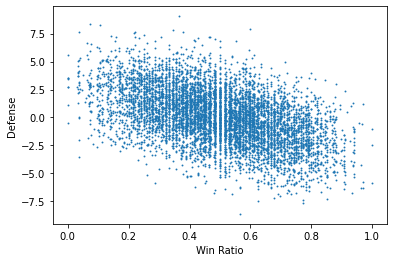

In [28]:
plt.scatter(df_features_d['WinRatio'],df_features_d['AvgDefense3pct'],s=0.8) #負相關
plt.xlabel('Win Ratio')
plt.ylabel('Defense')

Text(0, 0.5, 'AvgScoreGap')

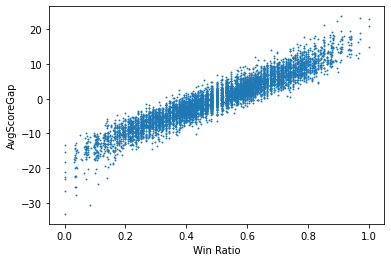

In [29]:
plt.scatter(df_features_d['WinRatio'],df_features_d['AvgScoreGap'],s=0.8) 
plt.xlabel('Win Ratio')
plt.ylabel('AvgScoreGap')

Text(0, 0.5, 'PointsRatio')

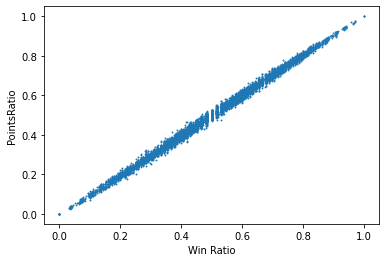

In [30]:
plt.scatter(df_features_d['WinRatio'],df_features_d['PointsRatio'],s=0.8) 
plt.xlabel('Win Ratio')
plt.ylabel('PointsRatio')

In [42]:
cols = ['Season', 'TeamID', 'TS', 'TOV', 'AstTO']
df_self = df_season_all[cols]

cols=['Season', 'TeamID', 'WinRatio', 'AvgScoreGap', 'PointsRatio', 'AvgDefense3pct']
df_pk = df_features_d[cols]

df_final = df_self.merge(df_pk)

## Tourney detailed results

In [43]:
df_tourney_d = pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv")
df_tourney_d.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [44]:
df_tourney_d = df_tourney_d.rename(columns={
   'WTeamID':'W_TeamID', 'LTeamID':'L_TeamID', 'WScore':'W_Score', 'LScore':'L_Score',
    'WLoc':'W_Loc'
})

In [45]:
df_tourney_d[df_tourney_d['Season']==2019]

,Season,DayNum,W_TeamID,W_Score,L_TeamID,L_Score,W_Loc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
1048,2019,134,1125,81,1396,70,N,0,28,53,9,23,16,21,3,30,15,11,6,4,12,28,71,7,22,7,13,15,24,13,11,7,1,22
1049,2019,134,1192,82,1341,76,N,0,30,55,9,21,13,19,13,27,12,17,1,8,10,28,64,15,28,5,7,10,17,17,12,9,1,19
1050,2019,135,1113,74,1385,65,N,0,22,49,5,12,25,33,6,36,12,21,5,2,18,22,69,8,31,13,23,16,27,9,16,11,1,22
1051,2019,135,1295,78,1300,74,N,0,25,52,9,20,19,24,8,21,12,6,0,3,14,24,57,9,21,17,21,15,23,17,9,0,2,20
1052,2019,136,1120,78,1308,77,N,0,26,57,12,31,14,21,6,18,13,10,9,2,24,25,51,7,25,20,27,11,28,14,16,6,2,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1120,77,1246,71,N,1,26,65,7,23,18,24,12,25,8,9,10,7,21,27,61,5,21,12,21,11,30,14,14,5,5,19
1111,2019,146,1277,68,1181,67,N,0,30,70,6,19,2,6,11,20,18,7,11,3,11,26,57,7,21,8,13,13,29,14,17,4,9,9
1112,2019,152,1403,61,1277,51,N,0,22,51,9,23,8,13,3,27,8,7,4,4,18,15,47,7,24,14,18,8,28,6,11,1,2,15
1113,2019,152,1438,63,1120,62,N,0,25,51,7,19,6,12,5,26,15,8,1,9,12,21,55,9,31,11,14,9,24,9,5,3,3,12


## 538 Ratings

In [46]:
df_538 = pd.read_csv("538ratingsMen.csv")
df_538.drop('TeamName', axis=1, inplace=True)

df_538

,Season,TeamID,538rating
0,2016,1242,94.46
1,2016,1314,93.94
2,2016,1438,92.46
3,2016,1277,91.84
4,2016,1328,89.96
...,...,...,...
403,2022,1313,71.42
404,2022,1411,70.37
405,2022,1168,71.79
406,2022,1136,71.56


# Feature Engineering

## Train data

In [47]:
# create team list
cols=['Season','DayNum','W_TeamID','L_TeamID','W_Score','L_Score']
df = df_tourney_d[cols].copy()
df

,Season,DayNum,W_TeamID,L_TeamID,W_Score,L_Score
0,2003,134,1421,1411,92,84
1,2003,136,1112,1436,80,51
2,2003,136,1113,1272,84,71
3,2003,136,1141,1166,79,73
4,2003,136,1143,1301,76,74
...,...,...,...,...,...,...
1176,2021,148,1211,1425,85,66
1177,2021,148,1417,1276,51,49
1178,2021,152,1124,1222,78,59
1179,2021,152,1211,1417,93,90


In [48]:
# merge with seeds
df = pd.merge(df, df_seeds, how='left', 
    left_on=['Season', 'W_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'Seed': 'W_Seed'})

df = pd.merge(df, df_seeds, how='left', 
    left_on=['Season', 'L_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'Seed': 'L_Seed'})

# only get the number, remove the region letter
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['W_Seed'] = df['W_Seed'].apply(treat_seed)
df['L_Seed'] = df['L_Seed'].apply(treat_seed)

In [49]:
# merge with features
df = pd.merge(df, df_final, how='left',
    left_on=['Season', 'W_TeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID', axis=1)

df = pd.merge(df, df_final, how='left',
    left_on=['Season', 'L_TeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID', axis=1)

In [50]:
# merge with 538
df = pd.merge(df, df_538, how='left',
    left_on=['Season', 'W_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'538rating': 'W_538rating'})

df = pd.merge(df, df_538, how='left', 
    left_on=['Season', 'L_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'538rating': 'L_538rating'})

In [51]:
def replace_win_loser(df):
    team_a = df.copy()
    team_b = df.copy()
    
    team_a_dict, team_b_dict = {}, {}
    
    for col in team_a.columns:
        if col.find('W_') == 0:
            new_col_name = str(col).replace('W_', 'A_')
            team_a_dict[col] = new_col_name
        if col.find('L_') == 0:
            new_col_name = str(col).replace('L_', 'B_')    
            team_a_dict[col] = new_col_name
        if col.find('_x') > 0:
            new_col_name = str(col).replace('_x', '_A')
            team_a_dict[col] = new_col_name
        if col.find('_y') > 0:
            new_col_name = str(col).replace('_y', '_B')    
            team_a_dict[col] = new_col_name
            
    for col in team_b.columns:
        if col.find('W_') == 0:
            new_col_name = str(col).replace('W_', 'B_')
            team_b_dict[col] = new_col_name
        if col.find('L_') == 0:
            new_col_name = str(col).replace('L_', 'A_')
            team_b_dict[col] = new_col_name
        if col.find('_x') > 0:
            new_col_name = str(col).replace('_x', '_B')
            team_b_dict[col] = new_col_name
        if col.find('_y') > 0:
            new_col_name = str(col).replace('_y', '_A')    
            team_b_dict[col] = new_col_name

    team_a = team_a.rename(columns = team_a_dict)
    team_b = team_b.rename(columns = team_b_dict)
    
    merged_df = pd.concat([team_a, team_b], axis = 0, sort = False)
    return merged_df

In [52]:
df = replace_win_loser(df).reset_index(drop=True)

In [53]:
# differences between A team and B team

cols_to_diff = ['Seed', '538rating']

for col in cols_to_diff:
    df[col + 'Diff'] = df['A_'+col] - df['B_'+col]
    
cols_to_diff2 = ['TS', 'TOV', 'AstTO', 'WinRatio','AvgScoreGap', 'PointsRatio', 'AvgDefense3pct']

for col in cols_to_diff2:
    df[col + 'Diff'] = df[col+'_A'] - df[col+'_B']

In [54]:
df.columns

Index(['Season', 'DayNum', 'A_TeamID', 'B_TeamID', 'A_Score', 'B_Score',
       'A_Seed', 'B_Seed', 'TS_A', 'TOV_A', 'AstTO_A', 'WinRatio_A',
       'AvgScoreGap_A', 'PointsRatio_A', 'AvgDefense3pct_A', 'TS_B', 'TOV_B',
       'AstTO_B', 'WinRatio_B', 'AvgScoreGap_B', 'PointsRatio_B',
       'AvgDefense3pct_B', 'A_538rating', 'B_538rating', 'SeedDiff',
       '538ratingDiff', 'TSDiff', 'TOVDiff', 'AstTODiff', 'WinRatioDiff',
       'AvgScoreGapDiff', 'PointsRatioDiff', 'AvgDefense3pctDiff'],
      dtype='object')

In [55]:
# Create target variable

df['ScoreDiff'] = df['A_Score'] - df['B_Score']
df['A_Win'] = (df['ScoreDiff'] > 0).astype(int)
df = df.drop(columns=['A_Score', 'B_Score','ScoreDiff'])

## Test data

In [57]:
df_test = pd.read_csv(DATA_PATH + "MSampleSubmissionStage2.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['A_TeamID'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['B_TeamID'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [58]:
# merge with seeds
df_test = pd.merge(df_test, df_seeds, how='left', 
    left_on=['Season', 'A_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'Seed': 'A_Seed'})

df_test = pd.merge(df_test, df_seeds, how='left', 
    left_on=['Season', 'B_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'Seed': 'B_Seed'})

# only get the number, remove the region letter
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_test['A_Seed'] = df_test['A_Seed'].apply(treat_seed)
df_test['B_Seed'] = df_test['B_Seed'].apply(treat_seed)

In [59]:
# merge with features
df_test = pd.merge(df_test, df_final, how='left',
    left_on=['Season', 'A_TeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID', axis=1)

df_test = pd.merge(df_test, df_final, how='left',
    left_on=['Season', 'B_TeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID', axis=1)

In [60]:
# merge with 538
df_test = pd.merge(df_test, df_538, how='left',
    left_on=['Season', 'A_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'538rating': 'A_538rating'})

df_test = pd.merge(df_test, df_538, how='left', 
    left_on=['Season', 'B_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'538rating': 'B_538rating'})

In [61]:
cols_to_diff = ['Seed', '538rating']

for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test['A_'+col] - df_test['B_'+col]
    
cols_to_diff2 = ['TS', 'TOV', 'AstTO', 'WinRatio','AvgScoreGap', 'PointsRatio', 'AvgDefense3pct']

for col in cols_to_diff2:
    df_test[col + 'Diff'] = df_test[col+'_x'] - df_test[col+'_y']

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2 = scaler.fit_transform(df)
df2 = pd.DataFrame(df2, columns=df.columns)

In [63]:
df2[['A_Win','SeedDiff', '538ratingDiff', 'TSDiff', 'TOVDiff', 'AstTODiff', 'WinRatioDiff', 'AvgDefense3pctDiff']].corr()

,A_Win,SeedDiff,538ratingDiff,TSDiff,TOVDiff,AstTODiff,WinRatioDiff,AvgDefense3pctDiff
A_Win,1.000000,-0.485451,0.499095,0.163807,-0.228238,0.247275,0.342834,-0.148699
SeedDiff,-0.485451,1.000000,-0.942709,-0.291486,0.357559,-0.436250,-0.628019,0.258020
538ratingDiff,0.499095,-0.942709,1.000000,0.416989,-0.366724,0.504613,0.614303,-0.240548
TSDiff,0.163807,-0.291486,0.416989,1.000000,-0.032622,0.417483,0.456288,0.001281
TOVDiff,-0.228238,0.357559,-0.366724,-0.032622,1.000000,-0.719289,-0.320923,0.022601
AstTODiff,0.247275,-0.436250,0.504613,0.417483,-0.719289,1.000000,0.442189,-0.017795
WinRatioDiff,0.342834,-0.628019,0.614303,0.456288,-0.320923,0.442189,1.000000,-0.290431
AvgDefense3pctDiff,-0.148699,0.258020,-0.240548,0.001281,0.022601,-0.017795,-0.290431,1.000000


# Build Model

## Model 1- simple XGBoost model

In [64]:
from sklearn import tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [66]:
target_feature = 'A_Win'
cols = ['Season', 'DayNum', 'A_Win','A_TeamID','B_TeamID']
features = [col for col in df.columns if col not in cols]
features = ['SeedDiff', '538ratingDiff', 'TSDiff', 'TOVDiff', 'AstTODiff', 'WinRatioDiff', 'AvgScoreGapDiff',
            'PointsRatioDiff', 'AvgDefense3pctDiff']
features = ['SeedDiff', '538ratingDiff', 'TSDiff', 'TOVDiff', 'AstTODiff', 'WinRatioDiff', 'AvgDefense3pctDiff']

In [67]:
df = df[df['Season'] >= 2016]
df = df.reset_index(drop=True)

In [68]:
s = 2020
train = df[df['Season']<s]
val = df[df['Season']>=s]
X_train = train[features].reset_index(drop = True).copy()
X_val = val[features].reset_index(drop = True).copy()
X_test = df_test[features].reset_index(drop = True).copy()

y_train = train[target_feature].reset_index(drop = True).copy()
y_val = val[target_feature].reset_index(drop = True).copy()

In [69]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [70]:
params = {'learning_rate':0.3,'max_depth':4,
          'grow_policy':'lossguide'
         }
model = XGBClassifier(**params, n_estimators=1024, random_state = 85, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 128)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1024, n_jobs=4, num_parallel_tree=1, random_state=85,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [71]:
# train
pred_train = model.predict_proba(X_train)[:, 1]
loss_train = log_loss(y_train, pred_train)
        
# val
pred_val = model.predict_proba(X_val)[:, 1]
loss_val = log_loss(y_val, pred_val)

# test
pred_test = model.predict_proba(X_test)[:, 1]

print(loss_train)
print(loss_val)

0.5075539972132711
0.630462891450434


<BarContainer object of 7 artists>

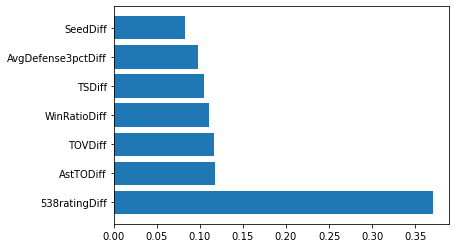

In [72]:
# feature importance
importance=pd.DataFrame()
importance['variable']=features
importance['gain'] = model.feature_importances_
# plot
data = importance.sort_values('gain', ascending=False).head(10)
plt.barh('variable','gain',data=data)

## Model 2- XGBoost model in function

In [74]:
def xgb_model(train_df, test_df, features, target_feature):
    print(features)
    
    i=1
    cvs_train = []
    cvs_val = []
    pred_test = np.zeros(len(test_df))
    preds_test = []
    pred_val_df = pd.DataFrame(np.zeros(len(train_df)),columns=['pred_val'])
    importancias=pd.DataFrame()
    importancias['variable']=features
    
    seasons = df['Season'].unique()
    for s in seasons[1:]:
        print(f'\nValidating on season {s}')
        X_train = train_df[train_df['Season'] < s][features].reset_index(drop = True).copy()
        X_val = train_df[train_df['Season'] == s][features].copy()
        val_index = X_val.index
    
        y_train = train_df[train_df['Season'] < s][target_feature].reset_index(drop = True).copy()
        y_val = train_df[train_df['Season'] == s][target_feature].reset_index(drop = True).copy()
    
        X_test = test_df[features].copy()
        
        # scale
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
        
        # model fit
        params = {'learning_rate':0.5,
                  'max_depth':4,
                  'grow_policy':'lossguide',
                  #'gamma':0.5
        }

        model = XGBClassifier(**params, n_estimators=1024, random_state = 85, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 128)
        importancias['gain_'+ str(i)] = model.feature_importances_
        i=i+1
        
        
        # train
        pred_train = model.predict_proba(X_train)[:, 1]
        loss_train = log_loss(y_train, pred_train)
        
        # val
        pred_val = model.predict_proba(X_val)[:, 1]
        print(pred_val)
        pred_val_df.iloc[val_index,0] = pd.Series(pred_val).values
        print(pred_val_df)
        loss_val = log_loss(y_val, pred_val)
        
        cvs_train.append(loss_train)
        cvs_val.append(loss_val)
        print(f'\t -> Scored {loss_val:.4f}')
        
        # test
        pred_test = model.predict_proba(X_test)[:, 1]
        preds_test.append(pred_test)

      
    importancias["gain_avg"]=importancias[["gain_1","gain_2","gain_3","gain_4"]].mean(axis=1)
    importancias=importancias.sort_values("gain_avg",ascending=False).reset_index(drop=True)

    predictions = np.mean(preds_test, 0)    
    result = {}
    result['cvs_train'] = cvs_train
    result['cvs_val'] = cvs_val
    result['importancias']=importancias
    result['pred_val'] = pred_val_df
    result['predictions'] = predictions

    
    return result

In [75]:
result1= xgb_model(df, df_test, features, target_feature)

['SeedDiff', '538ratingDiff', 'TSDiff', 'TOVDiff', 'AstTODiff', 'WinRatioDiff', 'AvgDefense3pctDiff']

Validating on season 2017
[0.39731467 0.39731467 0.39731467 0.62245935 0.5825702  0.704947
 0.5825702  0.704947   0.5825702  0.704947   0.62245935 0.62245935
 0.704947   0.5825702  0.5825702  0.5825702  0.5        0.704947
 0.704947   0.39731467 0.62245935 0.704947   0.5825702  0.5825702
 0.704947   0.704947   0.5825702  0.62245935 0.39731467 0.704947
 0.5825702  0.39731467 0.62245935 0.704947   0.31112355 0.5825702
 0.39731467 0.5        0.62245935 0.5825702  0.62245935 0.5
 0.31112355 0.31112355 0.5        0.704947   0.5        0.5
 0.704947   0.62245935 0.31112355 0.62245935 0.37754068 0.5
 0.62245935 0.31112355 0.39731467 0.5        0.704947   0.31112355
 0.5825702  0.5        0.39731467 0.31112355 0.704947   0.704947
 0.62245935 0.39731467 0.62245935 0.62245935 0.39731467 0.31112355
 0.31112355 0.31112355 0.31112355 0.31112355 0.31112355 0.39731467
 0.39731467 0.31112355 0.311123

training loss 0.4714478857639195
validation loss 0.601821955122822


<BarContainer object of 7 artists>

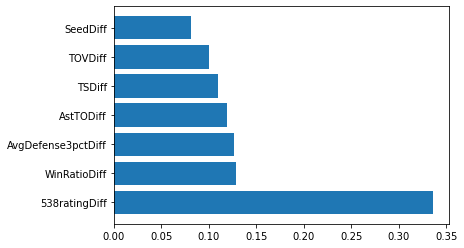

In [76]:
#print(result1['cvs_train'])
print('training loss', sum(result1['cvs_train']) / len(result1['cvs_train']))
#print( result1['cvs_val'])
print('validation loss', sum(result1['cvs_val']) / len(result1['cvs_val']))
data = result1['importancias'].sort_values('gain_avg', ascending=False)
plt.barh('variable','gain_avg',data=data)

In [77]:
# Submission
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = result1['predictions']
sub.to_csv('submission.csv', index = False)

### Evaluate the result

In [83]:
df_result = pd.concat([df.reset_index(drop=True), result1['pred_val']], axis=1)

In [85]:
df_result = df_result[df_result['pred_val'] > 0]

df_result['Win_pred'] = df_result['pred_val'].apply(lambda x: 1 if x >0.5 else 0)
df_result

/var/folders/jw/71kz1mm55lj8zynw1gmlz4_m0000gn/T/ipykernel_27336/2510688564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['Win_pred'] = df_result['pred_val'].apply(lambda x: 1 if x >0.5 else 0)


,Season,DayNum,A_TeamID,B_TeamID,A_Seed,B_Seed,TS_A,TOV_A,AstTO_A,WinRatio_A,AvgScoreGap_A,PointsRatio_A,AvgDefense3pct_A,TS_B,TOV_B,AstTO_B,WinRatio_B,AvgScoreGap_B,PointsRatio_B,AvgDefense3pct_B,A_538rating,B_538rating,SeedDiff,538ratingDiff,TSDiff,TOVDiff,AstTODiff,WinRatioDiff,AvgScoreGapDiff,PointsRatioDiff,AvgDefense3pctDiff,A_Win,pred_val,Win_pred
67,2017,134,1243,1448,11,11,0.563,0.170,1.146,0.606061,4.787879,0.601777,2.806955,0.591,0.144,1.317,0.593750,4.750000,0.597680,-0.894616,83.08,82.96,0,0.12,-0.028,0.026,-0.171,0.012311,0.037879,0.004097,3.701571,1,0.397315,0
68,2017,134,1291,1309,16,16,0.542,0.173,0.848,0.558824,-0.264706,0.554135,-0.472842,0.550,0.205,0.909,0.607143,1.321429,0.591015,-3.990012,69.78,69.24,0,0.54,-0.008,-0.032,-0.061,-0.048319,-1.586134,-0.036880,3.517171,1,0.397315,0
69,2017,135,1413,1300,16,16,0.528,0.177,0.881,0.625000,0.500000,0.612563,-1.287282,0.553,0.156,1.114,0.733333,9.433333,0.746102,-3.579746,69.94,71.04,0,-1.10,-0.025,0.021,-0.233,-0.108333,-8.933333,-0.133539,2.292464,1,0.397315,0
70,2017,135,1425,1344,11,11,0.564,0.138,1.372,0.727273,5.515152,0.723514,0.392515,0.552,0.165,1.127,0.625000,3.625000,0.623524,-1.730392,81.18,81.75,0,-0.57,0.012,-0.027,0.245,0.102273,1.890152,0.099990,2.122908,1,0.622459,1
71,2017,136,1112,1315,2,15,0.586,0.150,1.206,0.882353,10.823529,0.886191,-5.571387,0.575,0.168,1.070,0.678571,4.392857,0.691099,-0.766090,88.99,72.33,-13,16.66,0.011,-0.018,0.136,0.203782,6.430672,0.195092,-4.805297,1,0.582570,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,2021,148,1425,1211,6,1,0.552,0.152,1.128,0.758621,9.655172,0.777228,-0.427461,0.640,0.142,1.535,1.000000,23.000000,1.000000,-1.078083,85.76,96.51,5,-10.75,-0.088,0.010,-0.407,-0.241379,-13.344828,-0.222772,0.650622,0,0.194978,0
664,2021,148,1276,1417,1,11,0.587,0.141,1.449,0.833333,10.875000,0.846113,-1.695391,0.558,0.143,1.251,0.653846,4.346154,0.659542,1.134320,89.56,81.89,-10,7.67,0.029,-0.002,0.198,0.179487,6.528846,0.186571,-2.829711,0,0.710078,1
665,2021,152,1222,1124,2,1,0.553,0.128,1.348,0.884615,18.000000,0.892446,-4.872825,0.598,0.147,1.401,0.916667,17.958333,0.924768,0.474469,90.22,93.63,1,-3.41,-0.045,-0.019,-0.053,-0.032051,0.041667,-0.032322,-5.347293,0,0.399240,0
666,2021,152,1417,1211,11,1,0.558,0.143,1.251,0.653846,4.346154,0.659542,1.134320,0.640,0.142,1.535,1.000000,23.000000,1.000000,-1.078083,81.89,96.51,10,-14.62,-0.082,0.001,-0.284,-0.346154,-18.653846,-0.340458,2.212403,0,0.194978,0


In [86]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(accuracy_score(df_result['A_Win'], df_result['Win_pred']))
print(confusion_matrix(df_result['A_Win'], df_result['Win_pred']))
print(classification_report(df_result['A_Win'], df_result['Win_pred']))

0.6835205992509363
[[185  82]
 [ 87 180]]
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       267
           1       0.69      0.67      0.68       267

    accuracy                           0.68       534
   macro avg       0.68      0.68      0.68       534
weighted avg       0.68      0.68      0.68       534



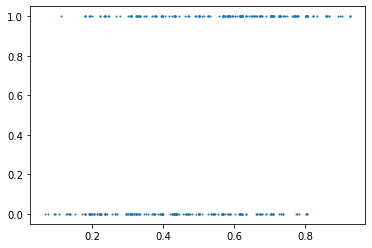

In [87]:
plt.scatter('pred_val','A_Win', s=1, data=df_result)

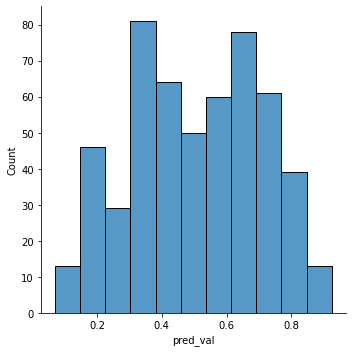

In [88]:
sns.displot(df_result['pred_val'])

## Model 3 - Random Forest

In [89]:
from sklearn.ensemble import RandomForestRegressor

rg = RandomForestRegressor(n_jobs=-1, random_state=2525)

In [90]:
target_feature = 'A_Win'
cols = ['Season', 'DayNum', 'A_Win','A_TeamID','B_TeamID']
features = ['SeedDiff', '538ratingDiff', 'TSDiff', 'TOVDiff', 'AstTODiff', 'WinRatioDiff', 'AvgDefense3pctDiff']

In [91]:
y_train = df[target_feature]
X_train = df[features]
X_test = df_test[features]

In [92]:
rg.fit(X_train, y_train)
y_pred = rg.predict(X_test)

In [93]:
# Submission
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = y_pred
sub.to_csv('submission_rf.csv', index = False)